In [208]:
import requests
import time
import nltk
import pandas as pd
import regex as re
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # NLP classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [209]:
url = 'https://www.reddit.com/hot.json'

In [210]:
headers = {'User-agent':'Eye eye bot 00'}

In [211]:
res = requests.get(url,headers=headers)

In [212]:
res.status_code

200

In [213]:
the_json = res.json()

In [214]:
sorted(the_json.keys())

['data', 'kind']

In [215]:
sorted(the_json['data'].keys())

['after', 'before', 'children', 'dist', 'geo_filter', 'modhash']

In [216]:
len(the_json['data']['children'])

25

In [217]:
pd.DataFrame(the_json['data']['children'])

,kind,data
0,t3,"{'approved_at_utc': None, 'subreddit': 'AskRed..."
1,t3,"{'approved_at_utc': None, 'subreddit': 'worldn..."
2,t3,"{'approved_at_utc': None, 'subreddit': 'wallst..."
3,t3,"{'approved_at_utc': None, 'subreddit': 'aww', ..."
4,t3,"{'approved_at_utc': None, 'subreddit': 'Wellth..."
5,t3,"{'approved_at_utc': None, 'subreddit': 'politi..."
6,t3,"{'approved_at_utc': None, 'subreddit': 'memes'..."
7,t3,"{'approved_at_utc': None, 'subreddit': 'Combat..."
8,t3,"{'approved_at_utc': None, 'subreddit': 'Bikini..."
9,t3,"{'approved_at_utc': None, 'subreddit': 'politi..."


In [218]:
the_json['data']['children'][0]['data']

{'approved_at_utc': None,
 'subreddit': 'AskReddit',
 'selftext': '',
 'author_fullname': 't2_4ttwva09',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 0,
 'clicked': False,
 'title': 'Film snobs of Reddit, who was the single worst casting choice in Hollywood film history?',
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/AskReddit',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': None,
 'downs': 0,
 'thumbnail_height': None,
 'top_awarded_type': None,
 'hide_score': False,
 'name': 't3_y01xtf',
 'quarantine': False,
 'link_flair_text_color': 'dark',
 'upvote_ratio': 0.92,
 'author_flair_background_color': None,
 'subreddit_type': 'public',
 'ups': 16813,
 'total_awards_received': 5,
 'media_embed': {},
 'thumbnail_width': None,
 'author_flair_template_id': None,
 'is_original_content': False,
 'user_reports': [],
 'secure_media': None,
 'is_reddit_media_domain': False,
 'is_meta': False,
 'category': None,
 'secure_media_embed': {},
 'link_flair_text': None,


In [219]:
len(the_json['data']['children'])

25

In [220]:
the_json['data']['after']

't3_y08ddj'

In [221]:
[post['data']['name'] for post in the_json['data']['children']]

['t3_y01xtf',
 't3_y0b8ob',
 't3_y0gnis',
 't3_y0gn5x',
 't3_xzze6l',
 't3_y0bbul',
 't3_y0d0ui',
 't3_y07k7i',
 't3_y0gkr2',
 't3_y0gvbl',
 't3_y06q08',
 't3_y0e7kl',
 't3_y0fbkj',
 't3_y0fe3h',
 't3_y0apl8',
 't3_y0amuo',
 't3_y07ac9',
 't3_y0d2zr',
 't3_y0c5vj',
 't3_y06y7c',
 't3_y088qb',
 't3_y0gloi',
 't3_y094zq',
 't3_y0h3jg',
 't3_y08ddj']

In [222]:
param = {'after':'t3_xz3tn3'}

In [223]:
requests.get(url,params =param, headers= headers )

<Response [200]>

In [224]:
# The function 'reddit_to_csv' will take three arguments: 
# 1. the subreddit being scraped; 2. the filename, or the name
# the csv file will be given; and 3. the number of requests 
# the user would like to make of reddit's API. 

def reddit_to_csv(subreddit, filename, n_requests=1):
    
    #Create an empty list to be used later in function:
    posts = []
    
    #Create User-Agent to avoid 429 res.status_code:
    headers = {'User-agent':'Eye eye bot 00'}
    
    #Establish that 'after' (a variable used later) is None type:
    after = None
    
    #for loop n_requests iterations (n_requests is established by user):
    for i in range(n_requests):
        print(i)
        
        if after == None:
            params = {}
        else:
            params = {'after': after}
        #Assign 'url' to reddit's base url, plus whatever subreddit 
        #the user provides,plus .json for clean results:
        #url = 'https://www.reddit.com/hot.json'
        url = 'https://www.reddit.com/' + str(subreddit) + '/.json'
        
        #Set my res variable equal to the results from requests.get, 
        #and the parameters set above like 'url' or 'params':
        res = requests.get(url,params=params,headers=headers)
        
        #Conditional statement to ensure access to the API is approved:
        if res.status_code ==200:
            the_json = res.json()
            
            for x in range(len(the_json['data']['children'])):
                
                #Create temporary dictionary to add results of each post to:
                temp_dict = {}
                #After looking through the json results, I've selected the below information about the posts
                #as those that can potentially add value to my model's results.
                temp_dict['subreddit'] = the_json['data']['children'][x]['data']['subreddit']
                temp_dict['title'] = the_json['data']['children'][x]['data']['title']
                temp_dict['post_paragraph'] = the_json['data']['children'][x]['data']['selftext']
                temp_dict['clicked'] = the_json['data']['children'][x]['data']['clicked']
                temp_dict['ups'] = the_json['data']['children'][x]['data']['ups']
                temp_dict['downs'] = the_json['data']['children'][x]['data']['downs']
                temp_dict['likes'] = the_json['data']['children'][x]['data']['likes']
                temp_dict['category'] = the_json['data']['children'][x]['data']['category']
                temp_dict['number_of_comments'] = the_json['data']['children'][x]['data']['num_comments']
                temp_dict['score'] = the_json['data']['children'][x]['data']['score']
                temp_dict['author_flair_css_class'] = the_json['data']['children'][x]['data']['author_flair_css_class']
                temp_dict['subreddit_type'] = the_json['data']['children'][x]['data']['subreddit_type']
                
                #Add the temporary dictionary to 'posts',the list of each post's dictionary of information:
                posts.append(temp_dict)
                #posts.extend(the_json['data']['children'])
            after = the_json['data']['after']
            
        else:
            print(res.status_code)
            break
        time.sleep(1)
        
    #Turn the list of post dictionaries into a pandas DataFrame:
    posts_df = pd.DataFrame(posts)
    
    #Drop any duplicate rows that may have been pulled:
    posts_df.drop_duplicates(inplace = True)
    
    #Rearrange the columns into a more logical order:
    posts_df = posts_df[['subreddit', 'title', 'clicked', 'ups', 'downs', 'post_paragraph', 'likes', 'number_of_comments', 'category', 'score', 'author_flair_css_class', 'subreddit_type']]
    
    #Save the DataFrame as a .csv file:
    posts_df.to_csv(str(filename), index = False, sep = ",")


        

In [225]:
#Load and save the data as CSV
reddit_to_csv(subreddit = 'r/bali',
              n_requests = 150,
              filename = 'mario_reddit_posts.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [226]:
#Load and save the data as CSV
reddit_to_csv(subreddit = 'r/phuket',
              n_requests = 150,
              filename = 'zelda_reddit_posts.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [227]:
mario_df = pd.read_csv('./mario_reddit_posts.csv')
mario_df.head(2)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type
0,bali,"Bali Talks - Monthly post for October, 2022",False,1,0,"Dear Community,\n\nThis is your place to discu...",NaN,10,NaN,1,NaN,public
1,bali,README: Entry Requirements,False,76,0,Below is a guide for international tourists lo...,NaN,112,NaN,76,NaN,public


In [228]:
mario_df.shape

(1273, 12)

In [229]:
zelda_df = pd.read_csv('./zelda_reddit_posts.csv')
zelda_df.head(2)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type
0,phuket,Cannabis in Phuket,False,6,0,"I just read about the ""legalization"" of cannab...",NaN,11,NaN,6,NaN,public
1,phuket,Taxi to patong,False,0,0,How much should i spend for a taxi from Karon ...,NaN,3,NaN,0,NaN,public


In [230]:
zelda_df.shape

(1330, 12)

**Appened the Mario and Zelda files**

In [231]:
df = mario_df.append(zelda_df, ignore_index=True)

In [232]:
df.shape

(2603, 12)

**CSV CHECKPOINT (check the data again).**

In [233]:
df.head(5)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type
0,bali,"Bali Talks - Monthly post for October, 2022",False,1,0,"Dear Community,\n\nThis is your place to discu...",NaN,10,NaN,1,NaN,public
1,bali,README: Entry Requirements,False,76,0,Below is a guide for international tourists lo...,NaN,112,NaN,76,NaN,public
2,bali,mma/boxing morning class close to Kuta,False,3,0,"Hi guys, going for 2 weeks. Will most likely s...",NaN,0,NaN,3,NaN,public
3,bali,Recommendations for private tours that pick up...,False,2,0,Would love any advice or recommendations. Stay...,NaN,0,NaN,2,NaN,public
4,bali,How do people get around Penida? Are there mot...,False,6,0,NaN,NaN,12,NaN,6,NaN,public


In [234]:
df.shape

(2603, 12)

In [235]:
zelda_df.shape

(1330, 12)

In [236]:
mario_df.shape

(1273, 12)

In [238]:
1330+1273

2603

**Create a 'target' column (will equal 1 if the post's subreddit is Mario, and 0 if the post's subreddit is Zelda. Ultimate):**

In [239]:
df['target'] = np.where(df['subreddit'] == 'mario', 1, 0)

In [240]:
df.head(3)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type,target
0,bali,"Bali Talks - Monthly post for October, 2022",False,1,0,"Dear Community,\n\nThis is your place to discu...",NaN,10,NaN,1,NaN,public,0
1,bali,README: Entry Requirements,False,76,0,Below is a guide for international tourists lo...,NaN,112,NaN,76,NaN,public,0
2,bali,mma/boxing morning class close to Kuta,False,3,0,"Hi guys, going for 2 weeks. Will most likely s...",NaN,0,NaN,3,NaN,public,0


**Look for columns that don't have any values and can be dropped**

In [241]:
df['likes'].isnull().sum()

2603

In [242]:
df['category'].isnull().sum()

2603

**The column 'clicked' is not empty, but the column values are purely False, therefore I will drop 'clicked' as well. The same for columns 'downs' and 'subreddit_type' which are purely 0's and 'public', respectively.**

In [243]:
df['clicked'].value_counts()

False    2603
Name: clicked, dtype: int64

In [244]:
df['downs'].value_counts()

0    2603
Name: downs, dtype: int64

In [245]:
df['subreddit_type'].value_counts()

public    2603
Name: subreddit_type, dtype: int64

In [246]:
df_drop_list = ['likes', 'category', 'clicked', 'downs', 'subreddit_type']

In [247]:
df.drop(df_drop_list, axis=1, inplace=True)

In [248]:
df.shape

(2603, 8)

In [249]:
df.to_csv('master_df.csv', index=False, sep=",")

**Set Tokenizer**

In [250]:
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

In [251]:
lemmatizer = WordNetLemmatizer()

In [252]:
df = pd.read_csv('./master_df.csv')

In [253]:
df.columns

Index(['subreddit', 'title', 'ups', 'post_paragraph', 'number_of_comments',
       'score', 'author_flair_css_class', 'target'],
      dtype='object')

**Create function that takes a column containing text and returns the lemmatized version in a new 'cleaned' column**

In [256]:
def column_cleaner(column, df=df):
    #For some reason, I was running into errors trying to run this code until I added the code
    #below (df[column+'_clean'] = ""), establishing from the beginning that the new column to be created
    #exists in the dataframe and contains nothing but empty strings.
    
    df[column+'_clean'] = ""
    
    #for loop through each row in the column:
    for i in range(len(df[column])):
        
        #Tokenize, or separate, each word in column's string into its own string (prep for lemmatization):
        col_tok = []
        col_tok.extend(tokenizer.tokenize(df[column][i].lower()))
        col_token = []
        [col_token.append(s) for s in col_tok if s not in col_token]
        
        #Lemmatize the words (cut the word to its base/root, for improved model results):
        col_lem = []
        for x in range(len(col_token)):
            col_lem.append(lemmatizer.lemmatize(col_token[x]))
        
        #Remove characters and numbers (for improved model results, hopefully):
        letters_only_col = []
        for c in range(len(col_lem)):
            letters_only_col.append(re.sub("[^a-zA-Z]", "", col_lem[c]))
        
        #Remove stopwords (for improved model results):
        col_words = [w for w in letters_only_col if not w in stopwords.words('english')]
        
        #Remove 'cheat' words (words that are in the subreddit's name and also in the column)
        cheat_words = ['beach']
        col_words = [w for w in letters_only_col if not w in cheat_words]
        
        #Ensure that there are no 'None' objects in title_words:
        col_words = list(filter(None, col_words))

        #Join the lemmatized words - stopwords back to one long string (prep for
        #vectorization, done outside/after this function):
        col_words = " ".join(col_words)

        #Fill new column with 'cleaned' string from column:
        df[column+'_clean'][i] = col_words

In [257]:
column_cleaner(column='title', df=df)

<ipython-input-256-dd4c21d39ae3>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column+'_clean'][i] = col_words


In [258]:
df['post_paragraph'].head()

0    Dear Community,\n\nThis is your place to discu...
1    Below is a guide for international tourists lo...
2    Hi guys, going for 2 weeks. Will most likely s...
3    Would love any advice or recommendations. Stay...
4                                                  NaN
Name: post_paragraph, dtype: object

In [259]:
df['post_paragraph'] = df['post_paragraph'].replace(np.nan, "")

In [260]:
column_cleaner(column='post_paragraph', df=df)

<ipython-input-256-dd4c21d39ae3>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column+'_clean'][i] = col_words


**Save version of DataFrame**

In [261]:
df.to_csv('master_df_cleaned.csv', index=False, sep=",")

In [262]:
df.head(3)

,subreddit,title,ups,post_paragraph,number_of_comments,score,author_flair_css_class,target,title_clean,post_paragraph_clean
0,bali,"Bali Talks - Monthly post for October, 2022",1,"Dear Community,\n\nThis is your place to discu...",10,1,NaN,0,bali talk monthly post for october,dear community this is your place to discus on...
1,bali,README: Entry Requirements,76,Below is a guide for international tourists lo...,112,76,NaN,0,readme entry requirement,below is a guide for international tourist loo...
2,bali,mma/boxing morning class close to Kuta,3,"Hi guys, going for 2 weeks. Will most likely s...",0,3,NaN,0,mma boxing morning class close to kuta,hi guy going for week will most likely stay in...


**Create CountVectorize Function**

In [263]:
def count_vec_column(column, func_df=df):
    #Instantiate CountVectorizer:
    vect = CountVectorizer()
    
    #Create temporary variable X_text that takes on the fit/transformed results of the column:
    X_text = vect.fit_transform(func_df[column])
    
    #Turn X_text into an array (prep to easily make a DataFrame):
    X_text = X_text.toarray()
    
    #Create a temporary DataFrame with each word/word-pair/word-group as the columns:
    temp_df = pd.DataFrame(X_text,
                           columns=vect.get_feature_names())
    
    #Add the original column name to the beginning of the new columns' names to differentiate from which column
    # the vectorized words came from (this may impact the strength of the model):
    for i in range(len(temp_df.columns)):
        #print(i)
        temp_df.rename(columns={temp_df.columns[i]: column + '_' + temp_df.columns[i]}, inplace=True)
    
    #Combine the two DataFrames:
    func_df = pd.concat([func_df, temp_df], axis=1, join_axes=[func_df.index])
    return func_df

**Create TF-IDF Function**

In [264]:
def tfidf_column(column, func_df=df):
    #Instantiate TfidfVectorizer:
    tfidf_vect = TfidfVectorizer()
    
    #Create temporary variable X_text that takes on the fit/transformed results of the column:
    X_text = tfidf_vect.fit_transform(func_df[column])
    
    #Turn X_text into an array (prep to easily make a DataFrame):
    X_text = X_text.toarray()
    
    #Create a temporary DataFrame with each word/word-pair/word-group as the columns:
    temp_df = pd.DataFrame(X_text,
                           columns=tfidf_vect.get_feature_names())
    
    #Add the original column name to the beginning of the new columns' names to differentiate from which column
    # the tf-idf vectorized words came from (this may impact the strength of the model):
    for i in range(len(temp_df.columns)):
        #print(i)
        temp_df.rename(columns={temp_df.columns[i]: column + '_' + temp_df.columns[i]}, inplace=True)
    
    #Combine the two DataFrames:
    func_df = pd.concat([func_df, temp_df], axis=1, join_axes=[func_df.index])
    return func_df

In [265]:
df

,subreddit,title,ups,post_paragraph,number_of_comments,score,author_flair_css_class,target,title_clean,post_paragraph_clean
0,bali,"Bali Talks - Monthly post for October, 2022",1,"Dear Community,\n\nThis is your place to discu...",10,1,NaN,0,bali talk monthly post for october,dear community this is your place to discus on...
1,bali,README: Entry Requirements,76,Below is a guide for international tourists lo...,112,76,NaN,0,readme entry requirement,below is a guide for international tourist loo...
2,bali,mma/boxing morning class close to Kuta,3,"Hi guys, going for 2 weeks. Will most likely s...",0,3,NaN,0,mma boxing morning class close to kuta,hi guy going for week will most likely stay in...
3,bali,Recommendations for private tours that pick up...,2,Would love any advice or recommendations. Stay...,0,2,NaN,0,recommendation for private tour that pick up f...,would love any advice or recommendation stayin...
4,bali,How do people get around Penida? Are there mot...,6,,12,6,NaN,0,how do people get around penida are there moto...,
...,...,...,...,...,...,...,...,...,...,...
2598,phuket,Patong Massage Parlors,8,,9,8,NaN,0,patong massage parlor,
2599,phuket,Bangla road and nightlife Patong,3,Hello . Was wondering what the nightlife is l...,7,3,NaN,0,bangla road and nightlife patong,hello wa wondering what the nightlife is like ...
2600,phuket,Worth it to move to Phuket for a few months?,15,I am a 21 year old male from Ireland. Wonderin...,35,15,NaN,0,worth it to move phuket for a few month,i am a year old male from ireland wondering wh...
2601,phuket,Comedy in English -- Rawai Beach,13,,4,13,NaN,0,comedy in english rawai,


In [266]:
X = df["title_clean"]
y = df["target"]

In [267]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

In [268]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2082,) (521,) (2082,) (521,)


In [269]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

In [270]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Check Stop_words: None or English.

pipe_params = {
    "cvec__max_features":[2000,3000,4000,5000],
    "cvec__min_df": [2,3],
    "cvec__max_df": [0.9,0.95],
    "cvec__ngram_range": [(1,1),(1,2)],
    "cvec__stop_words": [None,"english"]
}

# ngram_range of (1,1) just returns individual tokens
# ngram_range of (1,2) just returns individual tokens AND bi-grams

In [271]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [272]:
# Fit GridSearch to training data.
start_time = time.time()
gs.fit(X_train,y_train)
print(f"Runtime:{time.time()-start_time}")

Runtime:6.4960267543792725


In [273]:
# What's the best score?
gs.best_score_

1.0

In [274]:
# What's the best params?
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [275]:
# Score model on training set.
# What is the score on a classifier? Accuracy
gs.score(X_train,y_train)

1.0

In [276]:
# Score model on testing set.
gs.score(X_test,y_test)

1.0

In [277]:
# Let's set a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec = Pipeline([
    ("tvec", TfidfVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

In [278]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {"tvec__max_features" : [2000,3000,4000,5000],
                    "tvec__min_df": [2,3],
                    "tvec__max_df": [0.9,0.95],
                    "tvec__stop_words" : [None, "english"],
                    "tvec__ngram_range" : [(1,1),(1,2)]
                  }
    

In [279]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(estimator=pipe_tvec,
                      param_grid=pipe_tvec_params,
                      cv=5)

In [280]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [281]:
gs_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [282]:
# Score model on training set.
gs_tvec.score(X_train,y_train)

1.0

In [283]:
# Score model on testing set.
gs_tvec.score(X_test,y_test)

1.0

In [284]:
# Let's set a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec = Pipeline([
    ("tvec", TfidfVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {"tvec__max_features" : [100,500],
                    "tvec__stop_words" : [None, "english"],
                    "tvec__ngram_range" : [(1,1),(1,2)]
                  }
    

# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(estimator=pipe_tvec,
                      param_grid=pipe_tvec_params,
                      cv=5)

# Fit GridSearch to training data.
gs_tvec.fit(X_train,y_train)

gs_tvec.best_params_

# Score model on training set.
gs_tvec.score(X_train,y_train)

# Score model on testing set.
gs_tvec.score(X_test,y_test)

1.0

### Find top occuring words and remove

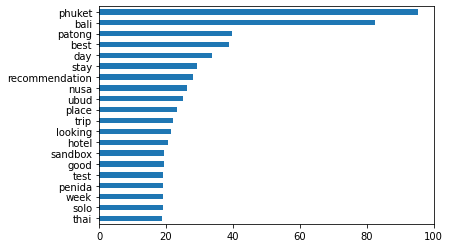

In [286]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words="english")

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())
# Plot top 20 occuring words
X_train_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh');

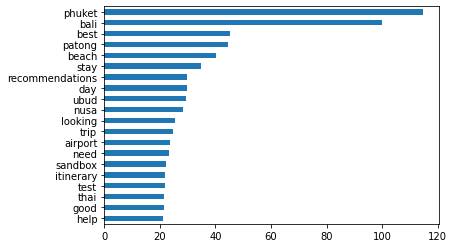

In [287]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words="english")

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(df["title"]).todense(), 
                          columns=tvec.get_feature_names_out())
# Plot top 20 occuring words
X_train_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh');

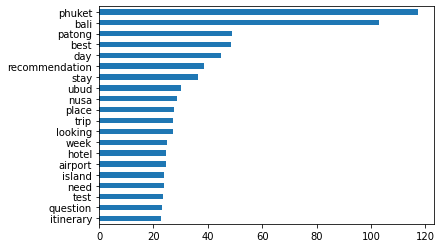

In [288]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words="english")

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(df["title_clean"]).todense(), 
                          columns=tvec.get_feature_names_out())
# Plot top 20 occuring words
X_train_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh');